In [1]:
import numpy as np 
import pandas as pd 

In [2]:
import cv2
import os 
from PIL import Image
images = []       
labels = [] 
train_path = 'train_zip/train'
for filename in os.listdir('train_zip/train'):
    if filename.split('.')[1] == 'jpg':
        img = cv2.imread(os.path.join(train_path,filename))
        ary=Image.fromarray(img,'RGB')
        r=ary.resize((50,50))
        labels.append(filename.split('_')[0])
        images.append(np.array(r))

In [3]:
dataset_path = "trai n_zip/train"

In [4]:
np.unique(labels)

array(['apple', 'banana', 'mixed', 'orange'], dtype='<U6')

In [5]:
from sklearn.preprocessing import LabelEncoder
la=LabelEncoder()
labels=pd.DataFrame(labels)
labels=la.fit_transform(labels[0])
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [6]:
!pip install norse torch torchvision
!pip install spikingjelly


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import torch
import numpy as np
import norse.torch as snn


images_tensor = torch.tensor(images).float() / 255.0  

def poisson_encode(image_tensor, time_steps=100):
    
    # Generate random values for each pixel for each time step(for batch of images)
    rand_values = torch.rand((time_steps, *image_tensor.shape))
    
    # Poisson spike trains: A spike occurs if the random value is less than the pixel intensity
    spikes = (rand_values < image_tensor.unsqueeze(0)).float()  # unsqueeze to add the time dimension
    return spikes

time_steps = 100  
encoded_images = poisson_encode(images_tensor, time_steps)

print(f"Encoded spike trains shape: {encoded_images.shape}")

C:\Users\vaish\AppData\Local\Temp\ipykernel_19284\3893626725.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  images_tensor = torch.tensor(images).float() / 255.0


Encoded spike trains shape: torch.Size([100, 240, 50, 50, 3])


# SNN using LIF neurons

In [8]:
import torch
import norse.torch as snn

class SNNModel(torch.nn.Module):
    def __init__(self):
        super(SNNModel, self).__init__()
        self.lif = snn.LIFCell()  

    def forward(self, inputs):
        time_steps, batch_size, height, width, channels = inputs.shape
        
        # Initialize the state for the LIF neuron with the shape of the input at a single time step
        initial_input = inputs[0]  # Take the first time step for the shape
        state = self.lif.initial_state(initial_input)

        # List to collect the output spikes for each time step
        spikes = []
        
        # Iterate through each time step
        for t in range(time_steps):
            # Feed the spike train for time step t into the LIF neuron
            z, state = self.lif(inputs[t], state)  # Pass input at time step t
            spikes.append(z)  # Collect the spikes

        # Stack the spikes into a tensor of shape (time_steps, batch_size, height, width, channels)
        return torch.stack(spikes)

snn_model = SNNModel()
output_spikes = snn_model(encoded_images)
print(f"Output spike shape: {output_spikes.shape}")  # Should be (time_steps, batch_size, height, width, channels)

Output spike shape: torch.Size([100, 240, 50, 50, 3])


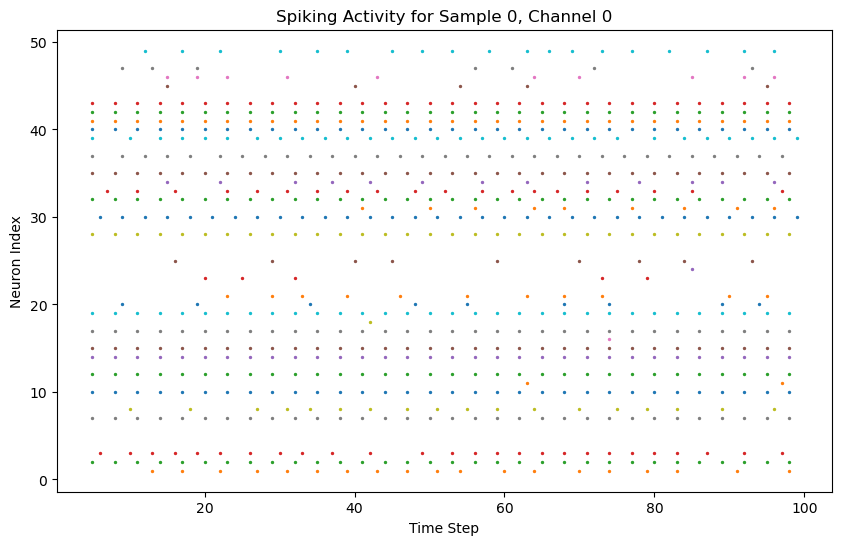

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_spiking_activity(spikes, num_neurons=10, sample_index=0, channel=0):
    
    # Get the spiking activity for the specified sample and channel
    spikes_sample = spikes[:, sample_index, :, :, channel].detach().cpu().numpy()
    
    # Flatten the spatial dimensions (height and width) to visualize them as "neurons"
    neurons_spikes = spikes_sample.reshape(spikes_sample.shape[0], -1)  # Shape: (time_steps, height*width)

    # Choose a subset of neurons to visualize
    num_total_neurons = neurons_spikes.shape[1]
    selected_neurons = np.random.choice(num_total_neurons, num_neurons, replace=False)
    
    plt.figure(figsize=(10, 6))
    for i, neuron_idx in enumerate(selected_neurons):
        spike_times = np.where(neurons_spikes[:, neuron_idx] > 0)[0]  # Get time steps where spikes occur
        plt.scatter(spike_times, np.ones_like(spike_times) * i, label=f'Neuron {neuron_idx}', s=2)

    plt.title(f'Spiking Activity for Sample {sample_index}, Channel {channel}')
    plt.xlabel('Time Step')
    plt.ylabel('Neuron Index')
    plt.show()

plot_spiking_activity(output_spikes, num_neurons=50, sample_index=0, channel=0)

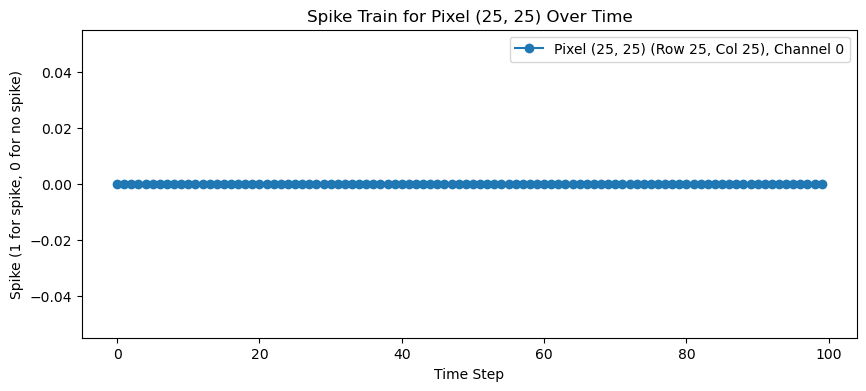

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_poisson_encoded_spikes(encoded_images, pixel_coords=(0, 0), sample_index=0, channel=0):
    """
    Visualizes the Poisson-encoded spike train for a specific pixel over time.
    """
    row, col = pixel_coords
    spike_train = encoded_images[:, sample_index, row, col, channel].detach().cpu().numpy()
    plt.figure(figsize=(10, 4))
    plt.plot(np.arange(len(spike_train)), spike_train, 'o-', label=f'Pixel {pixel_coords} (Row {row}, Col {col}), Channel {channel}')
    plt.xlabel('Time Step')
    plt.ylabel('Spike (1 for spike, 0 for no spike)')
    plt.title(f'Spike Train for Pixel {pixel_coords} Over Time')
    plt.legend()
    plt.show()

# Visualize the spike train for a specific pixel, for the first sample in the batch pixel over a set amount of time
visualize_poisson_encoded_spikes(encoded_images, pixel_coords=(25, 25), sample_index=0, channel=0)

In [11]:
def visualize_poisson_encoded_spikes2(encoded_images, pixel_coords=(0, 0), channel=0):
    
    row, col = pixel_coords
    spike_train = encoded_images[:, row, col, channel].detach().cpu().numpy()
    plt.figure(figsize=(10, 4))
    plt.plot(np.arange(len(spike_train)), spike_train, 'o-', label=f'Pixel {pixel_coords} (Row {row}, Col {col}), Channel {channel}')
    plt.xlabel('Time Step')
    plt.ylabel('Spike (1 for spike, 0 for no spike)')
    plt.title(f'Spike Train for Pixel {pixel_coords} Over Time')
    plt.legend()
    plt.show()

In [12]:
def load_random_image(dataset_path):
    filenames = [f for f in os.listdir(dataset_path) if f.endswith('.jpg')]
    random_image_path = os.path.join(dataset_path, np.random.choice(filenames))
    img = cv2.imread(random_image_path)  # Read the image using OpenCV
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR (OpenCV format) to RGB
    return img_rgb, random_image_path

In [13]:
def preprocess_image(img_rgb, size=(50, 50)):
    img_pil = Image.fromarray(img_rgb)  # Convert to PIL format and resize
    img_resized = img_pil.resize(size)
    img_resized = np.array(img_resized)

    # Normalize the pixel values to [0, 1]
    img_normalized = img_resized / 255.0
    return img_normalized

In [14]:
def plot_spiking_activity2(spikes, num_neurons=10, channel=0):

    # Get the spiking activity for the specified channel
    spikes_sample = spikes[:, :, :, channel].detach().cpu().numpy()

    # Flatten the spatial dimensions (height and width) to visualize them as "neurons"
    neurons_spikes = spikes_sample.reshape(spikes_sample.shape[0], -1)  # Shape: (time_steps, height*width)

    # Choose a subset of neurons to visualize
    num_total_neurons = neurons_spikes.shape[1]
    selected_neurons = np.random.choice(num_total_neurons, num_neurons, replace=False)

    plt.figure(figsize=(10, 6))
    for i, neuron_idx in enumerate(selected_neurons):
        spike_times = np.where(neurons_spikes[:, neuron_idx] > 0)[0]  # Get time steps where spikes occur
        plt.scatter(spike_times, np.ones_like(spike_times) * i, label=f'Neuron {neuron_idx}', s=2)

    plt.title(f'Spiking Activity for Channel {channel}')
    plt.xlabel('Time Step')
    plt.ylabel('Neuron Index')
    plt.show()

Loaded image from: train_zip/train\apple_49.jpg


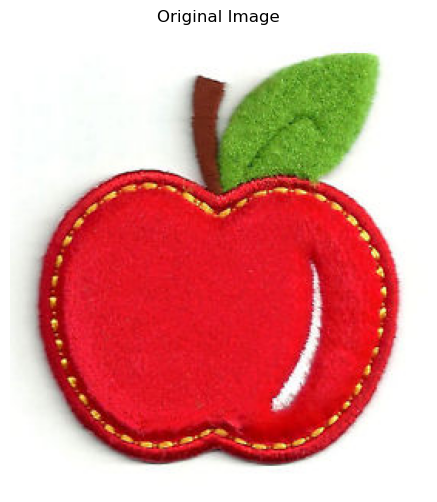

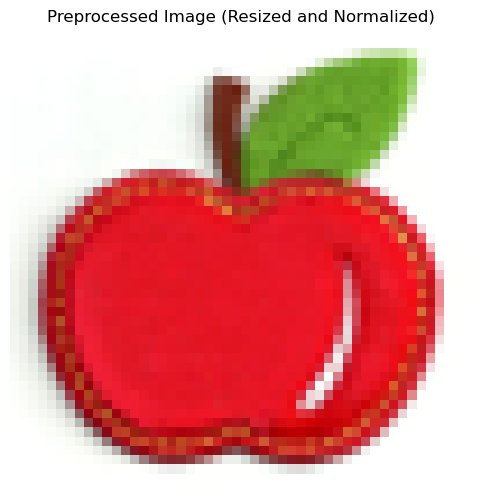

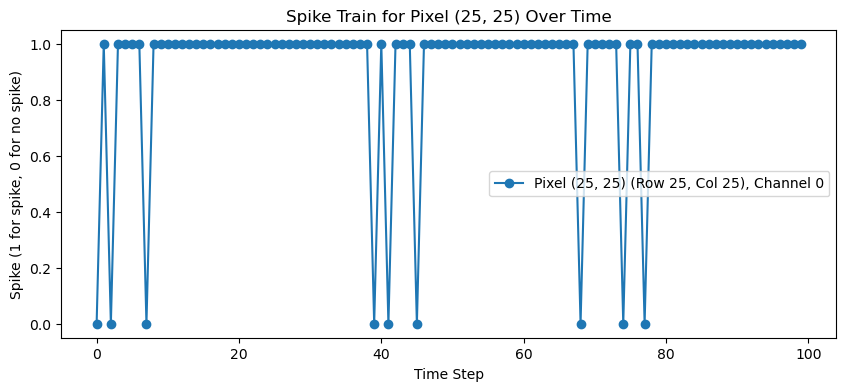

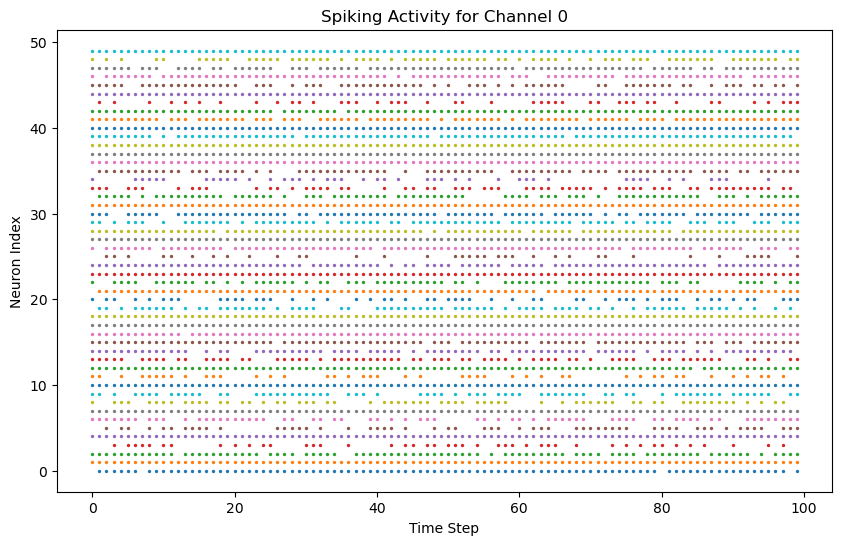

In [15]:
img_rgb, image_path = load_random_image(dataset_path)
print(f"Loaded image from: {image_path}")
    
plt.figure(figsize=(6, 6))
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis('off')
plt.show()

img_preprocessed = preprocess_image(img_rgb)
    
plt.figure(figsize=(6, 6))
plt.imshow(img_preprocessed)
plt.title("Preprocessed Image (Resized and Normalized)")
plt.axis('off')
plt.show()
img_tensor = torch.tensor(img_preprocessed).float()  # Convert to torch tensor
poisson_encoded = poisson_encode(img_tensor, time_steps=100)
    
# Display the Poisson-encoded spikes for a specific pixel
visualize_poisson_encoded_spikes2(poisson_encoded, pixel_coords=(25, 25), channel=0)  # Show spikes for the center pixel
    
#Visualize the spiking activity for a set of neurons
plot_spiking_activity2(poisson_encoded, num_neurons=50, channel=0) 

In [16]:
def reconstruct_image_from_spikes(spikes, channel=0):
    """
    Reconstructs an image from Poisson-encoded spike data by summing the spikes over time.
    Args:
    - spikes: Poisson-encoded spike trains (time_steps, height, width, channels).
    - channel: The color channel to reconstruct (0 for R, 1 for G, 2 for B).

    Returns:
    - Reconstructed image based on summed spikes.
    """
    # Sum the spikes across the time dimension
    summed_spikes = spikes[:, :, :, channel].sum(dim=0).cpu().numpy()  # Shape: (height, width)

    # Normalize the summed spikes to the range [0, 1]
    max_spikes = spikes.shape[0]  # Maximum possible spikes (time_steps)
    reconstructed_image = summed_spikes / max_spikes

    return reconstructed_image

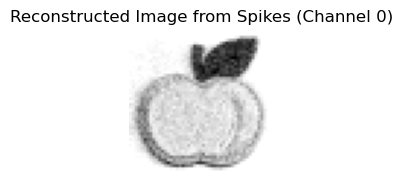

In [17]:
reconstructed_image = reconstruct_image_from_spikes(poisson_encoded, channel=0)  # Reconstruct from Red channel
plt.subplot(1, 3, 3)
plt.imshow(reconstructed_image, cmap='gray')
plt.title("Reconstructed Image from Spikes (Channel 0)")
plt.axis('off')
plt.show()

In [18]:
import torch
import norse.torch as snn

# Define a simple spiking neuron model using LIF neurons
class SNNModel(torch.nn.Module):
    def __init__(self):
        super(SNNModel, self).__init__()
        self.lif = snn.LIFCell()  # Leaky Integrate-and-Fire neuron

    def forward(self, inputs):
        time_steps, batch_size, height, width, channels = inputs.shape
        
        # Initialize the state for the LIF neuron
        state = self.lif.initial_state(inputs[0])  # Shape is based on the first time step

        spikes = []
        for t in range(time_steps):
            z, state = self.lif(inputs[t], state)  # LIF neuron processes the spikes over time
            spikes.append(z)  # Collect the spiking output from the LIF neuron

        return torch.stack(spikes)  # Stack the spikes back into a tensor

# Apply the LIF neuron model to the Poisson-encoded data
snn_model = SNNModel()
lif_encoded_spikes = snn_model(encoded_images)

print(f"LIF-encoded spike trains shape: {lif_encoded_spikes.shape}")

LIF-encoded spike trains shape: torch.Size([100, 240, 50, 50, 3])


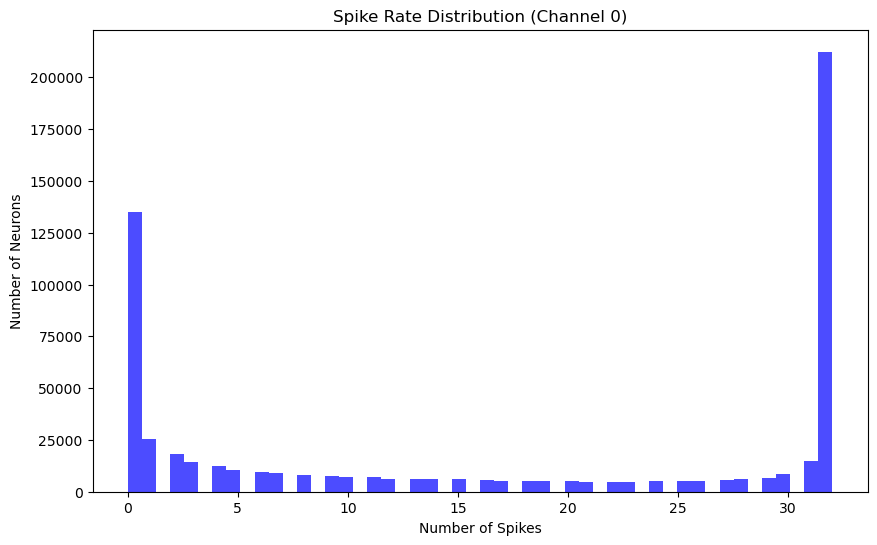

In [19]:
import matplotlib.pyplot as plt

def plot_spike_rate(lif_spikes, channel=0):
    """
    Plots the spike rate (number of spikes) across all neurons for a given channel.
    Args:
    - lif_spikes: Tensor of shape (time_steps, batch_size, height, width, channels) from the LIF-encoded spike trains.
    - channel: The color channel to analyze (0 for R, 1 for G, 2 for B).
    """
    # Sum the spikes over the time dimension to get the total number of spikes for each neuron
    spike_counts = lif_spikes[:, :, :, :, channel].sum(dim=0).detach().cpu().numpy()  # Shape: (batch_size, height, width)

    # Flatten the spike counts for plotting
    spike_counts_flat = spike_counts.reshape(-1)  # Flatten to 1D array of neuron spikes
    
    # Plot the spike rate distribution
    plt.figure(figsize=(10, 6))
    plt.hist(spike_counts_flat, bins=50, color='blue', alpha=0.7)
    plt.title(f'Spike Rate Distribution (Channel {channel})')
    plt.xlabel('Number of Spikes')
    plt.ylabel('Number of Neurons')
    plt.show()

plot_spike_rate(lif_encoded_spikes, channel=0)

# DEEP Q LEARNER

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.preprocessing import OneHotEncoder
import numpy as np

time_steps = 100      # Number of time steps in spike train
batch_size = 16      # Number of samples in a batch
height, width = 50, 50  # Spatial dimensions of each frame
channels = 3          # Number of channels (e.g., RGB)

lif_encoded_spikes = torch.rand(time_steps, batch_size, height, width, channels)
fruit_labels = ['apple', 'banana', 'mixed', 'orange']
num_classes = len(fruit_labels)


labels = np.random.choice(fruit_labels, size=batch_size)
encoder = OneHotEncoder(sparse=False)
labels_reshaped = np.array(labels).reshape(-1, 1)  # Reshape for the encoder
one_hot_labels = encoder.fit_transform(labels_reshaped)  # Shape: (batch_size, num_classes)
one_hot_labels = torch.tensor(one_hot_labels, dtype=torch.float32)

lif_encoded_spikes_min = lif_encoded_spikes.min(dim=0, keepdim=True)[0]
lif_encoded_spikes_max = lif_encoded_spikes.max(dim=0, keepdim=True)[0]

# Avoid division by zero in normalization
normalized_spikes = (lif_encoded_spikes - lif_encoded_spikes_min) / (lif_encoded_spikes_max - lif_encoded_spikes_min + 1e-5)

print(f"Normalized LIF-encoded spike trains shape: {normalized_spikes.shape}")  # (time_steps, batch_size, height, width, channels)
print(f"One-hot encoded labels shape: {one_hot_labels.shape}")  #(batch_size, num_classes)

Normalized LIF-encoded spike trains shape: torch.Size([100, 16, 50, 50, 3])
One-hot encoded labels shape: torch.Size([16, 4])


C:\Users\vaish\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint

class MemoryEfficientQNetwork(nn.Module):
    def __init__(self, time_steps, input_channels, height, width, num_classes):
        super(MemoryEfficientQNetwork, self).__init__()
        self.time_steps = time_steps
        self.input_channels = input_channels
        self.height = height
        self.width = width
        self.num_classes = num_classes
        
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        
        lstm_input_size = 32 * height * width
        self.lstm = nn.LSTM(input_size=lstm_input_size, hidden_size=128, batch_first=True)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        batch_size, time_steps, _, height, width = x.size()
        cnn_features = []

        for t in range(time_steps):
            frame = checkpoint.checkpoint(self.conv1, x[:, t])  
            frame = F.relu(frame)
            frame = checkpoint.checkpoint(self.conv2, frame)
            frame = F.relu(frame)
            frame = checkpoint.checkpoint(self.conv3, frame)
            frame = F.relu(frame)

            frame = frame.reshape(batch_size, -1)
            cnn_features.append(frame)

        # Stack the features for LSTM input
        cnn_features = torch.stack(cnn_features, dim=1)  # Shape: [batch_size, time_steps, lstm_input_size]
        lstm_out, _ = self.lstm(cnn_features)  # Shape: [batch_size, time_steps, 128]

        # Only retain the last output of LSTM to save memory in the final fully connected layer
        output = self.fc(lstm_out[:, -1, :])  # Shape: [batch_size, num_classes]

        return output

In [22]:
time_steps = 100     # Number of time steps in spike train
input_channels = 256 # Updated to match input tensor shape
height, width = 50, 50  # Spatial dimensions of each frame
num_classes = 4      # labels (apple, banana, mixed, orange)
batch_size = 8

q_network = MemoryEfficientQNetwork(time_steps, input_channels, height, width, num_classes)
sample_spike_input = torch.randn(time_steps, batch_size, height, width, input_channels)
sample_spike_input = sample_spike_input.permute(0, 1, 4, 2, 3)

q_values = q_network(sample_spike_input)
print(f"Q-values output shape: {q_values.shape}")

C:\Users\vaish\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\vaish\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Q-values output shape: torch.Size([100, 4])


# Reinforcement learning and Q value update

In [23]:
import torch
import torch.nn.functional as F
import random
from collections import deque, namedtuple

# Hyperparameters
gamma = 0.99               # Discount factor for future rewards
epsilon_start = 1.0        # Initial exploration rate
epsilon_end = 0.1          # Minimum exploration rate
epsilon_decay = 0.995      # Epsilon decay rate per episode
batch_size = 8             # Batch size for experience replay
buffer_size = 10000        # Replay buffer size
learning_rate = 1e-4       # Learning rate for Q-network
num_actions = 4            # Number of classification actions

In [24]:
# Initialize Q-network and target network
q_network = MemoryEfficientQNetwork(time_steps, input_channels, height, width, num_classes)
target_network = MemoryEfficientQNetwork(time_steps, input_channels, height, width, num_classes)
target_network.load_state_dict(q_network.state_dict())  # Start with same weights
target_network.eval()

MemoryEfficientQNetwork(
  (conv1): Conv2d(256, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lstm): LSTM(80000, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)

In [25]:
optimizer = torch.optim.Adam(q_network.parameters(), lr=learning_rate)

In [26]:
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])
replay_buffer = deque(maxlen=buffer_size)

In [27]:
# Epsilon-greedy policy for action selection
def select_action(state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, num_actions - 1)  # Explore: random action
    else:
        with torch.no_grad():
            q_values = q_network(state.unsqueeze(0))  # Add batch dimension
            return q_values.argmax(dim=1).item()         # Exploit: best action

In [ ]:
def reshape_to_five_dims(tensor):
    
    if tensor.dim() == 6:
        print(tensor.shape)
        # Combine the two channel dimensions: extra_channels * channels
        batch_size, time_steps, extra_channels, height, width, channels = tensor.shape
        combined_channels = extra_channels * channels
        tensor = tensor.view(batch_size, time_steps, combined_channels, height, width)
        print(tensor.shape)
        
    elif tensor.dim() < 5:
        raise RuntimeError(f"Expected 5 or 6 dimensions but got {tensor.dim()}.")
    elif tensor.dim() > 6:
        raise RuntimeError(f"Unexpected tensor with {tensor.dim()} dimensions.")
    return tensor

# def compute_q_values(batch):
#     states, actions, rewards, next_states, dones = batch

#     # Reshape `states` and `next_states` to ensure they are 5D
#     states = torch.stack(states)
#     states = reshape_to_five_dims(states).permute(1, 0, 2, 3, 4)  # Shape: [batch_size, time_steps, combined_channels, height, width]

#     next_states = torch.stack(next_states)
#     next_states = reshape_to_five_dims(next_states).permute(1, 0, 2, 3, 4)

#     # Current Q-values for chosen actions
#     q_values = q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    
#     # Next Q-values from the target network for next states
#     with torch.no_grad():
#         next_q_values = target_network(next_states).max(1)[0]
#         target_q_values = rewards + (gamma * next_q_values * (1 - dones))
    
#     return F.mse_loss(q_values, target_q_values)  # Compute the loss



import torch.nn.functional as F

def pad_to_max_size(tensor_list):
    """Efficiently pad tensors in a list to the same size along the channel and batch dimensions."""
    max_batch_size = max(tensor.size(1) for tensor in tensor_list)
    max_channels = max(tensor.size(-1) for tensor in tensor_list)
    padded_tensors = []

    for tensor in tensor_list:
        batch_size, channels = tensor.size(1), tensor.size(-1)
        
        # Minimal padding only when necessary
        batch_pad = max_batch_size - batch_size if batch_size < max_batch_size else 0
        channel_pad = max_channels - channels if channels < max_channels else 0
        
        # Pad only when needed, prioritizing batch dimension padding
        if batch_pad > 0 or channel_pad > 0:
            pad_tensor = F.pad(tensor, (0, 0, 0, 0, 0, channel_pad, 0, batch_pad))  # Efficient padding
            padded_tensors.append(pad_tensor)
        else:
            padded_tensors.append(tensor)
    
    return padded_tensors


def compute_q_values(batch):
    states, actions, rewards, next_states, dones = batch

    # Only pad if necessary and ensure consistent dimensions
    states = pad_to_max_size(states)
    next_states = pad_to_max_size(next_states)
    
    # Stack after padding to ensure uniform batch dimensions
    states = torch.stack(states)
    states = reshape_to_five_dims(states).permute(1, 0, 2, 3, 4)

    next_states = torch.stack(next_states)
    next_states = reshape_to_five_dims(next_states).permute(1, 0, 2, 3, 4)

    # Gather Q-values for chosen actions
    q_values = q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    
    # Compute target Q-values with gradient checkpointing for efficient backprop
    with torch.no_grad():
        next_q_values = target_network(next_states).max(1)[0]
        target_q_values = rewards + (gamma * next_q_values * (1 - dones))
    
    return F.mse_loss(q_values, target_q_values)



Training loop

In [29]:
num_episodes = 500  # Number of episodes
epsilon = epsilon_start
# Track accuracy
total_correct = 0
total_predictions = 0
accumulation_steps = 4  # Split batch size for gradient accumulation

In [ ]:
for episode in range(num_episodes):
    # Reset the environment and get the initial state (for simplicity, using random states here)
    state = torch.randn(time_steps, batch_size, height, width, input_channels)  # Example initial state
    state = state.float()  # Convert to float tensor

    done = False
    episode_reward = 0
    episode_correct = 0  # Count of correct predictions per episode

    while not done:
        # Select action using epsilon-greedy policy
        action = select_action(state, epsilon)
        
        # Simulate taking the action (simplified)
        next_state = torch.randn_like(state)  # Example next state
        reward = 1 if action == 0 else -1     # Rewarding correct classification, penalizing incorrect actions
        done = random.random() < 0.1          # Randomly end episode to simulate completion

        # Track accuracy
        if reward == 1:
            episode_correct += 1

        # Store experience in replay buffer
        replay_buffer.append(Experience(state, action, reward, next_state, done))
        
        # Sample a mini-batch from replay buffer and train
        if len(replay_buffer) >= batch_size:
            batch = random.sample(replay_buffer, batch_size)
            batch = Experience(*zip(*batch))
            states = batch.state
            actions = torch.tensor(batch.action)
            rewards = torch.tensor(batch.reward, dtype=torch.float32)
            next_states = batch.next_state
            dones = torch.tensor(batch.done, dtype=torch.float32)

            # Compute loss and optimize model
            loss = compute_q_values((states, actions, rewards, next_states, dones))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Update the state
        state = next_state
        episode_reward += reward

    # Decay epsilon for exploration-exploitation balance
    epsilon = max(epsilon_end, epsilon * epsilon_decay)
    
    # Update the target network periodically
    if episode % 10 == 0:
        target_network.load_state_dict(q_network.state_dict())

    # Track overall accuracy
    total_correct += episode_correct
    total_predictions += batch_size
    accuracy = (total_correct / total_predictions) * 100

    print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {episode_reward}, Epsilon: {epsilon:.2f}, "
          f"Episode Accuracy: {episode_correct/batch_size:.2f}, Cumulative Accuracy: {accuracy:.2f}%")